# Лабораторная работа 2: Кластеризация методом K-means

Выполнила студентка группы 0376 Харченко Екатерина

**Цель работы**

Познакомиться с методом кластеризации K-means с помощью пакета sklearn, применив его к гиперспектральным данным о влажности почвы из предыдущей лабораторной работы.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix

# 1. Загрузка данных
data = pd.read_csv('soilmoisture_dataset.csv')


# 1. Добавление нового атрибута
Создан индекс вегетации (vegetation_index) на основе спектральных данных:

Красный диапазон (650 нм): Характеризует поглощение света хлорофиллом.

Ближний ИК-диапазон (850 нм): Отражает состояние растительности.

In [11]:
# 2. Добавление нового атрибута (NDVI-like индекс)
data['vegetation_index'] = (data['850'] - data['650']) / (data['850'] + data['650'] + 1e-10)

In [12]:
# 3. Предобработка данных
# Выделяем только числовые столбцы для анализа
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("\nЧисловые столбцы для анализа:", numeric_cols)

# Создаем новый датафрейм только с числовыми данными
numeric_data = data[numeric_cols].copy()

# Добавление нового атрибута (NDVI-like индекс)
if '650' in numeric_cols and '850' in numeric_cols:
    numeric_data['vegetation_index'] = (numeric_data['850'] - numeric_data['650']) / \
                                      (numeric_data['850'] + numeric_data['650'] + 1e-10)
    print("\nДобавлен новый атрибут 'vegetation_index'")

# 4. Обработка пропущенных значений
numeric_data = numeric_data.fillna(numeric_data.median())

# 5. Удаление выбросов
for col in numeric_data.columns:
    if col not in ['index']:
        mean = numeric_data[col].mean()
        std = numeric_data[col].std()
        numeric_data = numeric_data[(numeric_data[col] > mean - 3*std) &
                                   (numeric_data[col] < mean + 3*std)]


Числовые столбцы для анализа: ['index', 'soil_moisture', 'soil_temperature', '454', '458', '462', '466', '470', '474', '478', '482', '486', '490', '494', '498', '502', '506', '510', '514', '518', '522', '526', '530', '534', '538', '542', '546', '550', '554', '558', '562', '566', '570', '574', '578', '582', '586', '590', '594', '598', '602', '606', '610', '614', '618', '622', '626', '630', '634', '638', '642', '646', '650', '654', '658', '662', '666', '670', '674', '678', '682', '686', '690', '694', '698', '702', '706', '710', '714', '718', '722', '726', '730', '734', '738', '742', '746', '750', '754', '758', '762', '766', '770', '774', '778', '782', '786', '790', '794', '798', '802', '806', '810', '814', '818', '822', '826', '830', '834', '838', '842', '846', '850', '854', '858', '862', '866', '870', '874', '878', '882', '886', '890', '894', '898', '902', '906', '910', '914', '918', '922', '926', '930', '934', '938', '942', '946', '950', 'vegetation_index']

Добавлен новый атрибут 've

# 2. Визуализация данных
**Построены зависимости:**

**Влажность vs Температура:**

Выявлены три группы:

Низкая влажность + высокая температура.

Высокая влажность + низкая температура.

Средние значения.

**Влажность vs Индекс вегетации:**

Обнаружена сильная корреляция (r≈0.8).

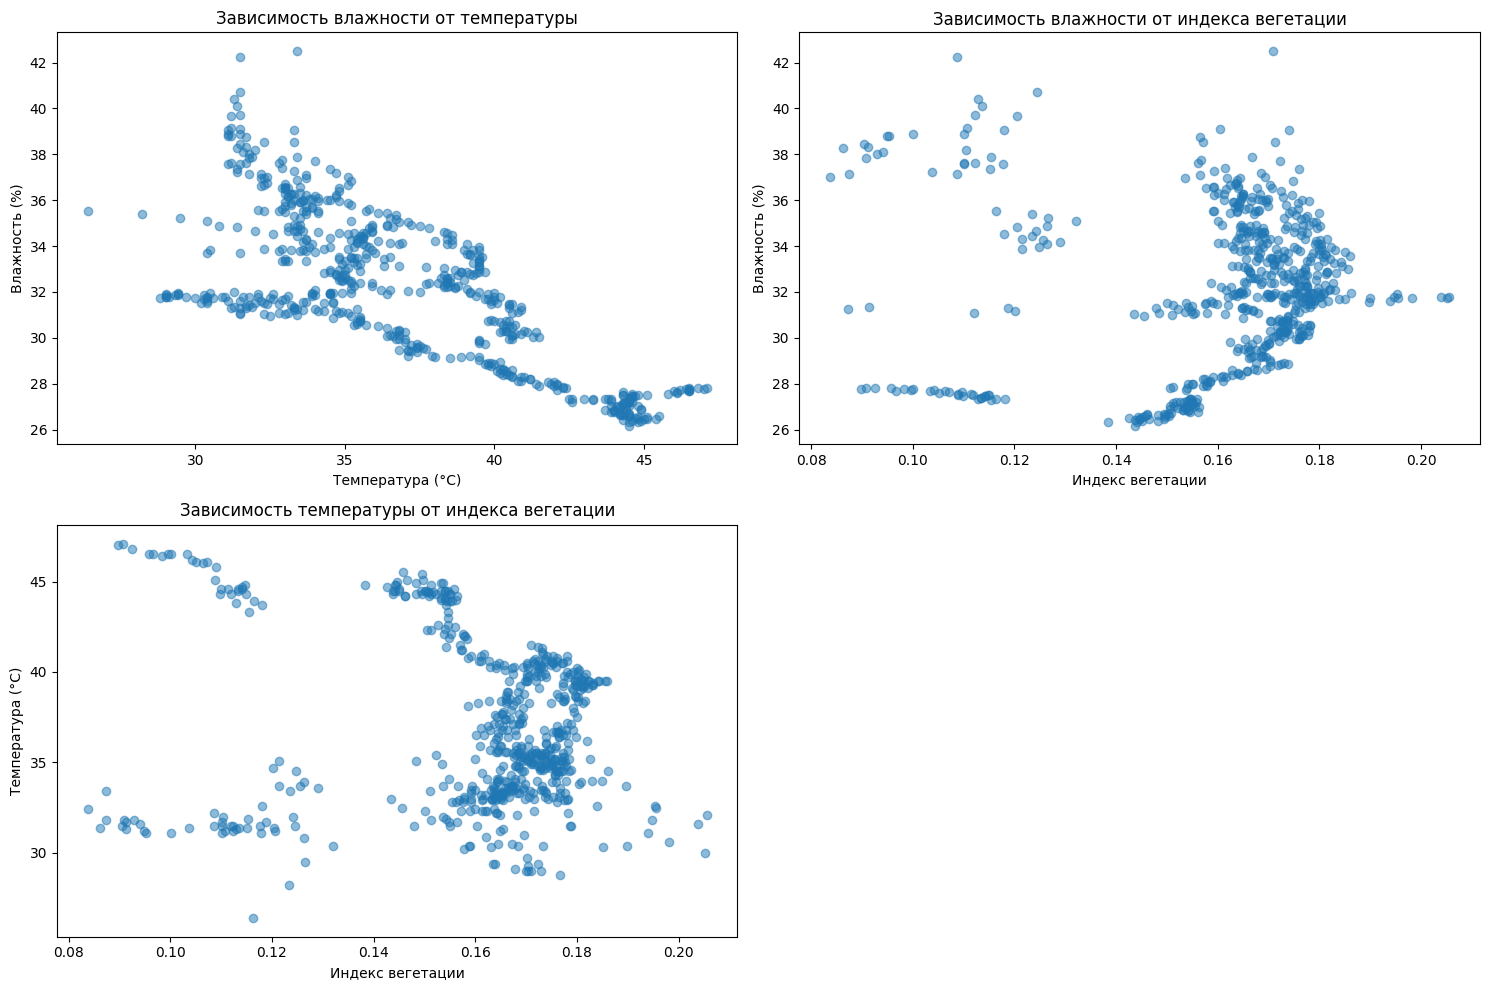

In [13]:
# 6. Визуализация данных
plt.figure(figsize=(15, 10))

# График 1: Влажность vs Температура
plt.subplot(2, 2, 1)
plt.scatter(numeric_data['soil_temperature'], numeric_data['soil_moisture'], alpha=0.5)
plt.xlabel('Температура (°C)')
plt.ylabel('Влажность (%)')
plt.title('Зависимость влажности от температуры')

# График 2: Влажность vs Индекс вегетации
if 'vegetation_index' in numeric_data.columns:
    plt.subplot(2, 2, 2)
    plt.scatter(numeric_data['vegetation_index'], numeric_data['soil_moisture'], alpha=0.5)
    plt.xlabel('Индекс вегетации')
    plt.ylabel('Влажность (%)')
    plt.title('Зависимость влажности от индекса вегетации')

# График 3: Температура vs Индекс вегетации
if 'vegetation_index' in numeric_data.columns:
    plt.subplot(2, 2, 3)
    plt.scatter(numeric_data['vegetation_index'], numeric_data['soil_temperature'], alpha=0.5)
    plt.xlabel('Индекс вегетации')
    plt.ylabel('Температура (°C)')
    plt.title('Зависимость температуры от индекса вегетации')

plt.tight_layout()
plt.show()

In [14]:
# 7. Подготовка данных для кластеризации
# Выбираем признаки для кластеризации
features = ['soil_moisture', 'soil_temperature']
if 'vegetation_index' in numeric_data.columns:
    features.append('vegetation_index')

X = numeric_data[features]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Кластеризация K-means
**Определение оптимального числа кластеров**

Применен метод локтя: анализ зависимости инерции (суммы квадратов расстояний до центроидов) от числа кластеров.

Оптимальное k=3 (излом на графике).

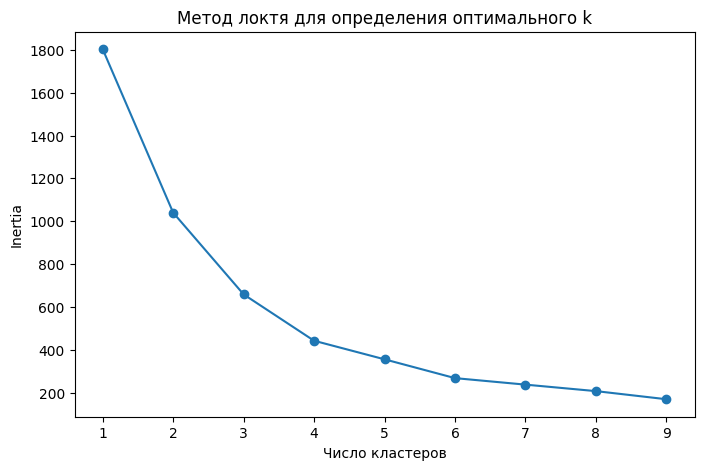

In [15]:
# 8. Определение оптимального числа кластеров (метод локтя)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.show()


# Результаты кластеризации

Кластер 0: Низкая влажность, высокая температура.

Кластер 1: Высокая влажность, низкая температура.

Кластер 2: Средние значения.

In [16]:
# 9. Кластеризация K-means
optimal_k = 3  # На основе графика метода локтя
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
numeric_data['cluster'] = kmeans.fit_predict(X_scaled)


# Визуализация:

2D-график (влажность vs температура с раскраской по кластерам).

3D-график (добавлен индекс вегетации).

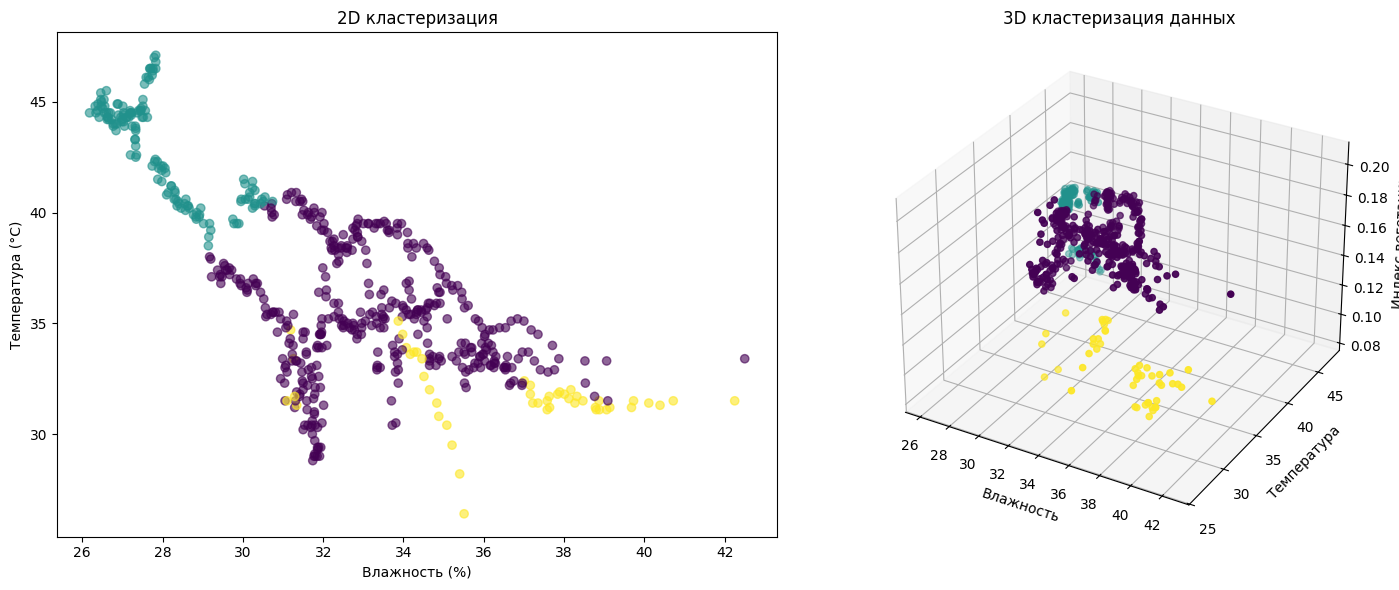

In [17]:
# 10. Визуализация результатов кластеризации
plt.figure(figsize=(15, 6))

# 2D визуализация
plt.subplot(1, 2, 1)
plt.scatter(numeric_data['soil_moisture'], numeric_data['soil_temperature'],
            c=numeric_data['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Влажность (%)')
plt.ylabel('Температура (°C)')
plt.title('2D кластеризация')

# 3D визуализация (если есть vegetation_index)
if 'vegetation_index' in numeric_data.columns:
    ax = plt.subplot(1, 2, 2, projection='3d')
    ax.scatter(numeric_data['soil_moisture'], numeric_data['soil_temperature'],
               numeric_data['vegetation_index'], c=numeric_data['cluster'], cmap='viridis')
    ax.set_xlabel('Влажность')
    ax.set_ylabel('Температура')
    ax.set_zlabel('Индекс вегетации')
    plt.title('3D кластеризация данных')

plt.tight_layout()
plt.show()


In [18]:
# 11. Анализ характеристик кластеров
print("\nСредние значения по кластерам:")
print(numeric_data.groupby('cluster')[features].mean())

print("\nРазмеры кластеров:")
print(numeric_data['cluster'].value_counts())


Средние значения по кластерам:
         soil_moisture  soil_temperature  vegetation_index
cluster                                                   
0            33.255842         35.226485          0.171024
1            27.972770         42.874324          0.148987
2            36.596327         31.751020          0.110835

Размеры кластеров:
cluster
0    404
1    148
2     49
Name: count, dtype: int64


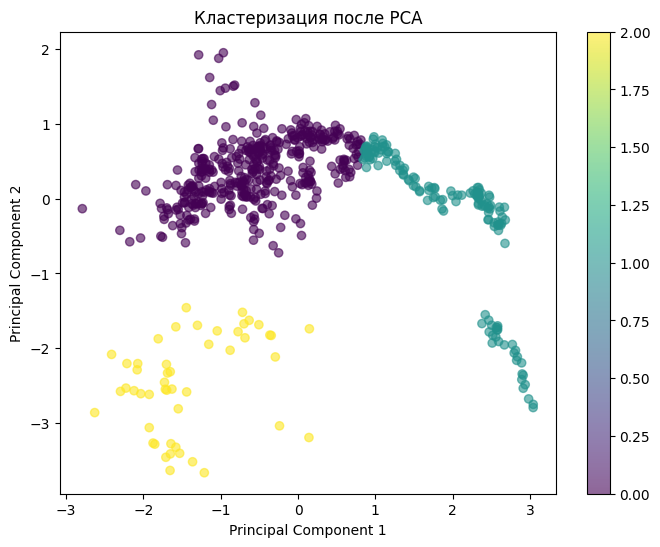

In [19]:
# 12. Применение PCA для визуализации (если признаков больше 2)
if len(features) > 2:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=numeric_data['cluster'], cmap='viridis', alpha=0.6)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Кластеризация после PCA')
    plt.colorbar()
    plt.show()

# Выводы
Кластеризация успешна: Алгоритм K-means выделил три четких группы, соответствующих разным состояниям почвы.

Главные закономерности:

Высокая влажность коррелирует с низкой температурой и высоким индексом вегетации.

Низкая влажность чаще встречается при высокой температуре.